# Bicycle-stations Availability Prediction

Use a supervised machine learning algorithm to predict the availability for each bicyle-sharing stations in Lyon (France) based on the history data.

I use the tree method [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) to predict a "probability" of bikes availability for each station. A number close to 1. means that you have several available bikes. A number close to 0. means you don't have many bikes.

## Some Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [3]:
import xgboost as xgb
from xgboost import plot_tree

/Users/babou/anaconda/envs/python3DS/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
import folium

In [6]:
%load_ext watermark

In [7]:
%watermark -d -v -p numpy,pandas,xgboost,matplotlib,folium -g -m -w

2018-05-30 

CPython 3.5.1
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
xgboost 0.6
matplotlib 2.0.2
folium 0.5.0

compiler   : GCC 4.2.1 (Apple Inc. build 5577)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : c480226b781fdeeb879124b13a3f6b68c9cd5642
watermark 1.5.0


The module `prediction.py` contains some functions dedicated to the bicyle-sharing stations predictions.

In [8]:
from prediction import (datareader, complete_data, cleanup, bikes_probability,
                        time_resampling, prepare_data_for_training, fit, prediction,
                       get_weather)
np.random.seed(42)

## Read and prepare the data

In [9]:
DATAFILE = './data/lyon.csv'

In [11]:
raw = datareader(DATAFILE)

2018-05-30 11:20:25,678 [85498] INFO     prediction: read the file './data/lyon.csv'


In [12]:
raw[raw['number'] == 1005].tail()

,number,last_update,bike_stands,available_bike_stands,available_bikes,availabilitycode,availability,bonus,status
7522659,1005,2017-09-26 14:31:50,10,10,0,3,Orange,Non,OPEN
7523006,1005,2017-09-26 14:41:54,10,10,0,3,Orange,Non,OPEN
7523353,1005,2017-09-26 14:41:54,10,10,0,3,Orange,Non,OPEN
7523700,1005,2017-09-26 14:51:57,10,10,0,3,Orange,Non,OPEN
7524047,1005,2017-09-26 14:55:17,10,10,0,3,Orange,Non,OPEN


Min and max dates of the timeseries

In [13]:
print(raw.last_update.min())
print(raw.last_update.max())

2017-07-08 00:30:12
2017-09-26 14:58:46


In [14]:
raw[(raw.number == 1001) &(raw.last_update >= "2017-07-26 09:00:00")].head(10)

,number,last_update,bike_stands,available_bike_stands,available_bikes,availabilitycode,availability,bonus,status
1613382,1001,2017-07-26 09:04:23,16,13,3,1,Vert,Non,OPEN
1613730,1001,2017-07-26 09:05:33,16,14,2,1,Vert,Non,OPEN
1614078,1001,2017-07-26 09:05:33,16,14,2,1,Vert,Non,OPEN
1614426,1001,2017-07-26 09:18:02,16,16,0,3,Orange,Non,OPEN
1614774,1001,2017-07-26 09:18:02,16,16,0,3,Orange,Non,OPEN
1615122,1001,2017-07-26 09:28:07,16,16,0,3,Orange,Non,OPEN
1615470,1001,2017-07-26 09:29:43,16,15,1,1,Vert,Non,OPEN
1615818,1001,2017-07-26 09:36:35,16,14,2,1,Vert,Non,OPEN
1616166,1001,2017-07-26 09:39:16,16,14,2,1,Vert,Non,OPEN
1616514,1001,2017-07-26 09:49:21,16,15,1,1,Vert,Non,OPEN


In [15]:
df_clean = cleanup(raw)

2018-05-30 11:20:45,209 [85498] INFO     prediction: cleanup processing


Pipe some processing data functions :

* time resampling to get data every 10 minutes (i.e. `10T`)
* add some columns : day of the week, hour of the day, etc.
* compute the bikes (number) "probability". It's just a normalization for each station with `num_avail_bikes / total`

In [16]:
df_clean.head()

,station,ts,stands,bikes,bonus,status
0,10063,2017-07-08 23:49:09,10,23,Non,OPEN
2,8038,2017-07-08 23:49:26,6,14,Non,OPEN
3,7045,2017-07-08 23:52:43,13,7,Non,OPEN
4,6045,2017-07-08 23:52:14,7,8,Non,OPEN
5,7062,2017-07-08 23:57:27,5,11,Non,OPEN


In [17]:
df = (df_clean.pipe(time_resampling)
      .pipe(complete_data)
      .pipe(bikes_probability))

2018-05-30 11:20:51,046 [85498] INFO     prediction: Time resampling for each station by '10T'
2018-05-30 11:20:59,356 [85498] INFO     prediction: complete some data
2018-05-30 11:22:00,897 [85498] INFO     prediction: bikes probability


In [18]:
import gc
del df_clean
del raw
gc.collect()

61

In [19]:
df.head()

,station,ts,bikes,stands,is_open,day,hour,minute,probability
0,1001,2017-07-09 00:00:00,15.0,1.0,1.0,6,0,0,0.93750
1,1001,2017-07-09 00:10:00,15.0,1.0,1.0,6,0,10,0.93750
2,1001,2017-07-09 00:20:00,14.5,1.5,1.0,6,0,20,0.90625
3,1001,2017-07-09 00:30:00,14.5,1.5,1.0,6,0,30,0.90625
4,1001,2017-07-09 00:40:00,11.5,4.5,1.0,6,0,40,0.71875


In [20]:
df.shape

(3880901, 9)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880901 entries, 0 to 3880900
Data columns (total 9 columns):
station        int64
ts             datetime64[ns]
bikes          float64
stands         float64
is_open        float64
day            int64
hour           int64
minute         int64
probability    float64
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 266.5 MB


**WIP**

In [ ]:
from numpy import fft
def fourierExtrapolation(x, segments, harmo):
    n = x.size
    n_harm = round((n * harmo / 100) -0.5) # number of harmonics in model
    print(n_harm)
    t = np.arange(0, n)
    p = np.polyfit(t, x, 2)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + segments)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [ ]:
def plot_fourrier(data,station, segments=5, harmo=10, return_df=False):
    
    lags = 550
    my_wine = data.loc[(data.station == station)].copy()
    
    X1 = my_wine[:-segments].tail(lags).copy()
    X2 = my_wine[-segments:].tail(lags).copy()
    
    extrapolation = fourierExtrapolation(X1.probability, segments, harmo)
    
    X1['fourrier'] = extrapolation[:-segments]
    X2['fourrier'] = extrapolation[-segments:]
    
    #plot
    fig, (axis1) = plt.subplots(1 ,figsize=(15,5))
    # Axe 1
    axis1.plot(X1.ts, X1.probability, '-', label='Historical')
    axis1.plot(X2.ts, X2.probability, '-', label='Reality')
    axis1.plot(X1.ts, X1.fourrier, '-', label='fourrier Train')
    axis1.plot(X2.ts, X2.fourrier, '-', label='fourrier extrapolation')
    
    plt.legend(loc='best')
    #plt.title(title)
    
    if return_df is True:
        return my_wine

In [ ]:
lol = plot_fourrier(df, station=12001, segments=12, harmo=10, return_df=True)

In [ ]:
ok = fourierExtrapolation(lol.probability, segments=10, harmo=5)
len(ok)

In [195]:
lol['ff'] = ok[0:len(lol)]

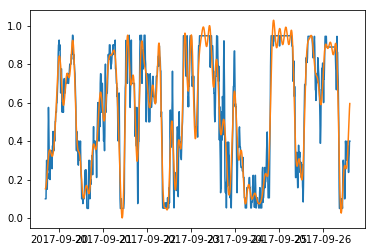

In [199]:
lag = 1000
plt.plot(lol.ts.tail(lag), lol.probability.tail(lag))
plt.plot(lol.ts.tail(lag), lol.ff.tail(lag))

In [179]:
ok

array([ 0.32282496,  0.32820109,  0.33357722,  0.33895335,  0.34432948,
        0.34970561,  0.35508174,  0.36045787,  0.365834  ,  0.37121013,
        0.37658626,  0.38196239,  0.38733852,  0.39271465,  0.39809078,
        0.40346691,  0.40884304,  0.41421917,  0.4195953 ,  0.42497142])

In [176]:
ok

array([ 0.77140794,  0.8524127 ,  0.86706836, ...,  0.26172551,
        0.16631123,  0.11497797])

In [171]:
lol['ff'] = ok

11467

In [150]:
len(ok)

11460

In [151]:
len(lol)

11450

In [144]:
fft.fft(lol.probability)[0:2]

array([ 5072.94970184 +0.j        ,  -331.07366223-82.17605142j])

In [137]:
lol.tail()

,station,ts,bikes,stands,is_open,day,hour,minute,probability,date,fft
22928,1002,2017-09-26 14:10:00,5.0,17.0,1.0,1,14,10,0.227273,2017-09-26,(-171.788087592+87.1589375286j)
22929,1002,2017-09-26 14:20:00,2.0,19.5,1.0,1,14,20,0.093023,2017-09-26,(-72.7384019554-121.274762818j)
22930,1002,2017-09-26 14:30:00,2.0,20.0,1.0,1,14,30,0.090909,2017-09-26,(-210.787479074+182.78960152j)
22931,1002,2017-09-26 14:40:00,3.0,19.0,1.0,1,14,40,0.136364,2017-09-26,(-5.05692277419+0.000912249385151j)
22932,1002,2017-09-26 14:50:00,6.0,16.0,1.0,1,14,50,0.272727,2017-09-26,(-331.073662233+82.1760514231j)


2017-11-10 14:37:20,462 [14571] WARNING  py.warnings: /Users/babou/anaconda/envs/python3DS/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



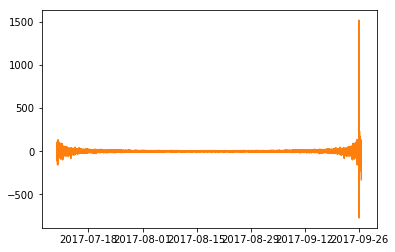

In [136]:
plt.plot(lol[120:].ts, lol[120:].probability)
plt.plot(lol[120:].ts, lol[120:].fft)

In [79]:
data = df[df.station == 1001]

In [80]:
data.head()

,station,ts,bikes,stands,is_open,day,hour,minute,probability,date
0,1001,2017-07-09 00:00:00,15.0,1.0,1.0,6,0,0,0.93750,2017-07-09
1,1001,2017-07-09 00:10:00,15.0,1.0,1.0,6,0,10,0.93750,2017-07-09
2,1001,2017-07-09 00:20:00,14.5,1.5,1.0,6,0,20,0.90625,2017-07-09
3,1001,2017-07-09 00:30:00,14.5,1.5,1.0,6,0,30,0.90625,2017-07-09
4,1001,2017-07-09 00:40:00,11.5,4.5,1.0,6,0,40,0.71875,2017-07-09


In [81]:
lol = fft.rfft(data.probability)

In [82]:
data.shape

(11466, 10)

In [83]:
x = data.probability

In [86]:
x[0:5]

0    0.93750
1    0.93750
2    0.90625
3    0.90625
4    0.71875
Name: probability, dtype: float64

In [96]:
n = x.size
n_harm = 3                     # number of harmonics in model
t = np.arange(0, n)
p = np.polyfit(t, x, 2)         # find linear trend in x
x_notrend = x - p[0] * t        # detrended x
x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
f = fft.fftfreq(n)              # frequencies
indexes = list(range(n))

In [95]:
range(2005 - 3, 2005 + 4, 1)

range(2002, 2009)

This is the final dataset. For further prediction, I could add some weather forecasts data to these features.

## Prediction

Let's select a time window (start, stop) to a single prediction.

* Two weeks of data for training
* Predict the 'probability' for the next 30 minutes and 1 hour for every station.
* Split the dataset into train and test dataset
* Compute the RMSE (Root Mean Squared Error) between the observations (i.e. probability) and the predicted values

In [21]:
#start = pd.Timestamp("2017-08-01T00:10:00") # Tuesday OLD
start = pd.Timestamp("2017-08-01T02:00:00") # Tuesday
predict_date = pd.Timestamp("2017-09-22T09:00:00") # wednesday
# predict the next 30 minutes
freq = '1H'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
periods = 1

In [22]:
prepare_data_for_training??

In [22]:
#train_X, train_Y, test_X, test_Y  
#X, y 
#train_X, train_Y, test_X, test_Y  
train_X, train_Y, test_X, test_Y  = prepare_data_for_training(df,
                                 predict_date,
                                 freq=freq,
                                 start=start,
                                 periods=periods,
                                 observation='probability',
                                # how=None
                                )

2018-02-13 17:28:18,082 [31214] INFO     prediction: prepare data for training
2018-02-13 17:28:18,083 [31214] INFO     prediction: New version 9
2018-02-13 17:28:18,084 [31214] INFO     prediction: Get summer holiday features
2018-02-13 17:28:30,058 [31214] INFO     prediction: Get public holiday features
2018-02-13 17:28:40,472 [31214] INFO     prediction: compute delta with  public holiday on '5' days
2018-02-13 17:28:41,386 [31214] INFO     prediction: Get cluster station features
2018-02-13 17:28:41,694 [31214] INFO     prediction: Get Geo cluster station features
2018-02-13 17:28:41,978 [31214] INFO     prediction: Get ratio station open by time
2018-02-13 17:28:42,846 [31214] INFO     prediction: Get ratio station geo cluster open by time
2018-02-13 17:28:44,104 [31214] INFO     prediction: Create Bin hours of the day
2018-02-13 17:28:45,389 [31214] INFO     prediction: sort values (station, ts)
2018-02-13 17:28:46,417 [31214] INFO     prediction: compute the future availability

### Rolling Validation

In [ ]:
def fit_rolling(train_X, train_Y, test_X, test_Y, param, num_round=25):
    """Train the xgboost model

    Return the booster trained model
    """
    # param = {'objective': 'reg:linear'}

    #if param
    #param = {'objective': 'reg:logistic'}
    #param['eta'] = 0.2
    #param['max_depth'] = 4 # 6 original
    #param['silent'] = 1
    #param['nthread'] = 4
    # used num_class only for classification (e.g. a level of availability)
    # param = {'objective': 'multi:softmax'}
    # param['num_class'] = train_Y.nunique()
    xg_train = xgb.DMatrix(train_X, label=train_Y)
    xg_test = xgb.DMatrix(test_X, label=test_Y)
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    evals_result = {}
    bst = xgb.train(param, xg_train, num_round, watchlist, evals_result=evals_result)
    return bst, evals_result

In [3]:
result = [] # All macro result by fold
learning_progress = {} # micro result by fold
pred_serie = np.full(X.shape[0], np.nan) # Store pred during the rolling windows
fold_serie = np.full(X.shape[0], np.nan) # Store fold during the rolling windows

tscv = TimeSeriesSplit(n_splits=3)
for (train_index, test_index), k in zip (tscv.split(X), range(1, tscv.n_splits+1, 1)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    print("Train : ")
    print(X_train.index.min())
    print(X_train.index.max())
    print(len(X_train))
    print("Test  : ")
    print(X_test.index.min())
    print(X_test.index.max())
    print(len(X_test))
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Split tranning for XGB
    X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train,
                                              test_size=0.33, random_state=42)
    
    # Adding Meteo features
    # Learning for Xgb
    X_tr = get_weather(X_tr, how='learning')
    X_te = get_weather(X_te, how='forecast', freq=freq)
    
    X_test = get_weather(X_test, how='forecast', freq=freq)
    
    # Learning XGB$
    # the 'booster'
    param ={"objective": "reg:logistic",
              "booster" : "gbtree",
              "eta": 0.2,
              "max_depth": 9,
              "silent": 1,
              "seed": 42}
    bst, evals_result = fit_rolling(X_tr, y_tr, X_te, y_te, param, num_round=60)
    
    pred = prediction(bst, X_test, y_test)
    rmse = np.sqrt(np.mean((pred - y_test)**2))
    
    pred_serie[test_index] = pred
    fold_serie[test_index] = k
    
    learning_progress[tscv.n_splits] = evals_result
    
    result.append({'fold' : k,
                  'train_min_date' : X_train.index.min(),
                  'train_max_date' : X_train.index.max(),
                   'len_train' : len(X_train),
                  'test_min_date' : X_test.index.min(),
                  'test_max_date' : X_test.index.max(),
                   'len_test' : len(X_test),
                  'rmse_train' : evals_result['train']['rmse'][-1],
                  'rmse_test' : evals_result['test']['rmse'][-1],
                  'rmse_validation' : rmse})
    print("---------------------------------------------")
df_result = pd.DataFrame(result)
X['pred'] = pred_serie
X['fold'] = fold_serie

NameError: name 'np' is not defined

In [45]:
df_result.head()

,fold,len_test,len_train,rmse_test,rmse_train,rmse_validation,test_max_date,test_min_date,train_max_date,train_min_date
0,1,632150,632151,0.180164,0.165386,0.244768,2017-08-26 23:30:00,2017-08-14 00:40:00,2017-08-14 00:40:00,2017-08-01 02:00:00
1,2,632150,1264301,0.193480,0.183436,0.245872,2017-09-08 22:20:00,2017-08-26 23:30:00,2017-08-26 23:30:00,2017-08-01 02:00:00
2,3,632150,1896451,0.201394,0.194458,0.246370,2017-09-21 21:00:00,2017-09-08 22:20:00,2017-09-08 22:20:00,2017-08-01 02:00:00


In [201]:
df_result.head()

,fold,len_test,len_train,rmse_test,rmse_train,rmse_validation,test_max_date,test_min_date,train_max_date,train_min_date
0,3,637743,637746,0.092354,0.083158,0.096094,2017-08-27 05:00:00,2017-08-14 03:30:00,2017-08-14 03:30:00,2017-08-01 02:00:00
1,3,637743,1275489,0.092316,0.086886,0.105826,2017-09-09 06:30:00,2017-08-27 05:00:00,2017-08-27 05:00:00,2017-08-01 02:00:00
2,3,637743,1913232,0.095415,0.091773,0.109602,2017-09-22 08:00:00,2017-09-09 06:30:00,2017-09-09 06:30:00,2017-08-01 02:00:00


In [202]:
X['y'] = y

In [203]:
X.tail()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,total_stand,filling_station_by_geo_cluster,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax,pred,fold,y
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-22 08:00:00,11001,1.0,17.0,1.0,4,8,0,0,0,0.0,...,18.0,0.359069,0.088889,0.087707,0.001182,0.007796,1.013481,0.136377,3.0,0.222222
2017-09-22 08:00:00,11002,16.0,4.0,1.0,4,8,0,0,0,0.0,...,20.0,0.386667,0.735000,0.736834,-0.001834,0.541573,0.997511,0.590673,3.0,0.600000
2017-09-22 08:00:00,11003,17.0,3.0,1.0,4,8,0,0,0,0.0,...,20.0,0.359069,0.865000,0.868574,-0.003574,0.751316,0.995885,0.813607,3.0,0.800000
2017-09-22 08:00:00,12001,5.0,20.0,1.0,4,8,0,0,0,0.0,...,25.0,0.340893,0.202000,0.200820,0.001180,0.040566,1.005878,0.363851,3.0,0.420000
2017-09-22 08:00:00,12002,2.0,18.0,1.0,4,8,0,0,0,0.0,...,20.0,0.340893,0.055000,0.056097,-0.001097,0.003085,0.980447,0.112957,3.0,0.050000


In [239]:
#import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_station_pred(result, station):
    """Plot available bikes and bike stands for a given station"""
    
    data = result[result.station == station].copy()
    
    nb_flod = data.fold.nunique()
    
    fig, axarr = plt.subplots(nb_flod ,figsize=(17,10))
    
    for i in range(0, nb_flod):
        fold_data = data[data.fold == i+1]
        rmse_fold = np.round(np.sqrt(np.mean((fold_data.pred - fold_data.y)**2)), 3)
        axarr[i].plot(fold_data[fold_data.is_open == 1].index, fold_data[fold_data.is_open == 1].y,
                      '-', label='Open', alpha=0.6)
        axarr[i].plot(fold_data[fold_data.is_open == 0].index, fold_data[fold_data.is_open == 0].y,
                      '-', label='Closed', alpha=0.6)
        axarr[i].plot(fold_data.index, fold_data.pred, 'r-', label='Prediction')
        axarr[i].set_title('Fold '+str(i+1)+' : RMSE '+str(rmse_fold), fontsize =25)
    
    ##ax = plt.gca()
    # set major ticks location every day
    ##ax.xaxis.set_major_locator(mdates.DayLocator())
    # set major ticks format
    ##ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n\n%a %d.%m.%Y'))
    # set minor ticks location every two hours
    ##ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    # set minor ticks format
    ##ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ##plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    plt.legend(loc='best')
    fig.tight_layout()
#    print("TRAIN")
#    print(train.tail(5))
#    print("DATA")
#    print(data)

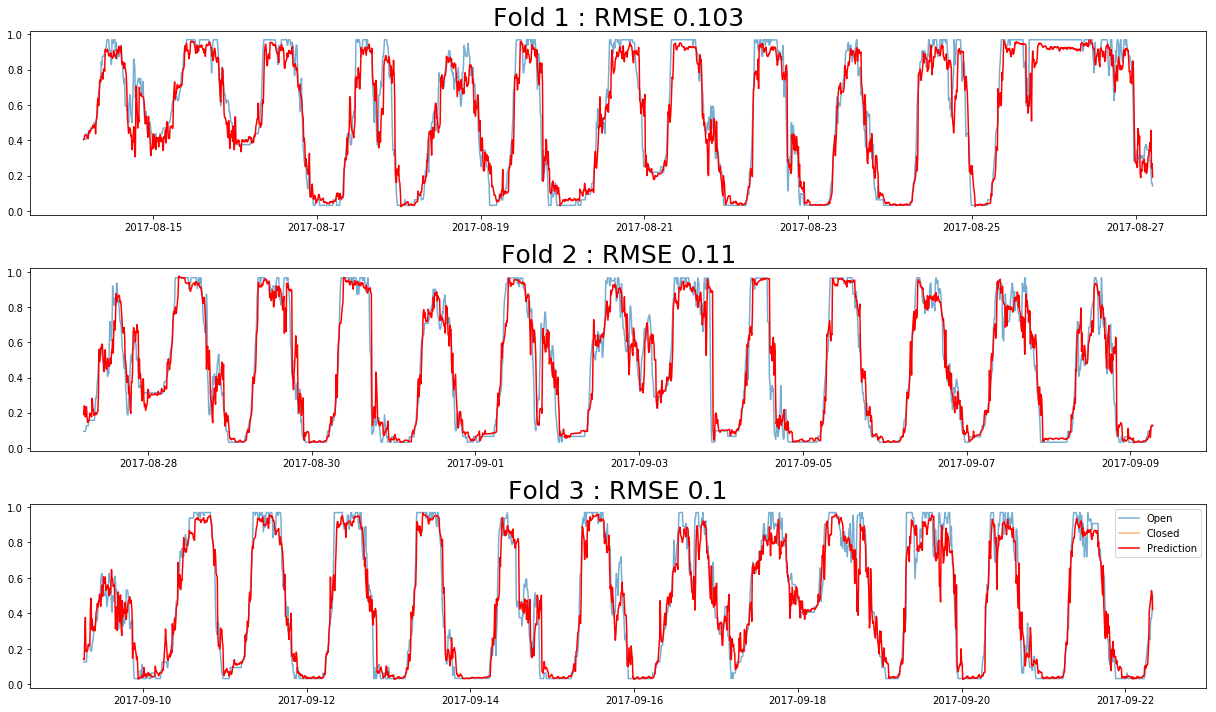

In [243]:
plot_station_pred(X, station=2005)

### Single Validation

The `fit` function create some data structure for the XGBoost from the train and test DataFrames (i.e. `xgb.DMatrix)`, configure the model and launch it with the `objective: 'reg:logistic'`. It's a regression, not a classification.

In [23]:
# Spliting train in learning / validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, 
                                                    test_size=0.33, random_state=42)

In [24]:
X_train.tail()

,station,bikes,stands,is_open,day,hour,minute,probability,is_holiday,public_holiday,...,filling_station_by_geo_cluster,mean_6,std_9,median_6,mean_6_minus_median_6,mean_6_multi_median_6,mean_6_ratio_median_6,warning_empty_full,rolling_sum_9_empty_full_station,proba_mean_by_sta_day_binned_hour
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-03 08:10:00,3102,1.0,15.0,1.0,3,8,10,0.062500,1,0,...,0.418919,0.135417,0.103645,0.125000,1.041667e-02,0.016927,1.083333,1,3.0,0.259223
2017-09-04 18:10:00,5002,11.0,7.0,1.0,0,18,10,0.611111,0,0,...,0.332661,0.611111,0.027778,0.611111,1.765255e-14,0.373457,1.000000,0,0.0,0.435836
2017-09-18 08:20:00,10030,4.0,14.0,1.0,0,8,20,0.222222,0,0,...,0.508080,0.226852,0.035258,0.222222,4.629630e-03,0.050412,1.020833,0,0.0,0.541058
2017-09-15 17:50:00,6036,2.5,19.5,1.0,4,17,50,0.113636,0,0,...,0.454545,0.428823,0.301153,0.443182,-1.435870e-02,0.190047,0.967601,0,2.0,NaN
2017-09-15 13:00:00,1035,6.0,10.0,1.0,4,13,0,0.375000,0,0,...,0.345997,0.359375,0.038273,0.375000,-1.562500e-02,0.134766,0.958333,0,0.0,0.171875


In [25]:
# Adding Meteo features
# Learning for Xgb
X_train = get_weather(X_train, how='learning')
X_test = get_weather(X_test, how='forecast', freq=freq)

# Value in futur
test_X = get_weather(test_X, how='forecast', freq=freq)

In [26]:
# the 'booster'
param ={"objective": "reg:logistic",
          "booster" : "gbtree",
          "eta": 0.2,
          "max_depth": 9,
          "silent": 1,
          "seed": 42}
bst = fit(X_train, y_train, X_test, y_test, param, num_round=60)

2018-02-13 17:29:42,726 [31214] INFO     prediction: fit


[0]	train-rmse:0.272245	test-rmse:0.272204
[1]	train-rmse:0.232445	test-rmse:0.232539
[2]	train-rmse:0.202643	test-rmse:0.202854
[3]	train-rmse:0.180608	test-rmse:0.180925
[4]	train-rmse:0.164537	test-rmse:0.164953
[5]	train-rmse:0.152986	test-rmse:0.153485
[6]	train-rmse:0.144806	test-rmse:0.145376
[7]	train-rmse:0.139083	test-rmse:0.139721
[8]	train-rmse:0.135079	test-rmse:0.135787
[9]	train-rmse:0.132289	test-rmse:0.133059
[10]	train-rmse:0.13033	test-rmse:0.131156
[11]	train-rmse:0.128871	test-rmse:0.129752
[12]	train-rmse:0.127844	test-rmse:0.128771
[13]	train-rmse:0.127072	test-rmse:0.128054
[14]	train-rmse:0.126421	test-rmse:0.127455
[15]	train-rmse:0.125928	test-rmse:0.127013
[16]	train-rmse:0.125413	test-rmse:0.126544
[17]	train-rmse:0.125023	test-rmse:0.126207
[18]	train-rmse:0.124475	test-rmse:0.125737
[19]	train-rmse:0.124167	test-rmse:0.125485
[20]	train-rmse:0.123746	test-rmse:0.125119
[21]	train-rmse:0.123438	test-rmse:0.124873
[22]	train-rmse:0.123011	test-rmse:0.124507

In [27]:
# compute the prediction from test_* (Validation)
pred = prediction(bst, test_X, test_Y)

In [28]:
pred[:5]

array([ 0.28615296,  0.30260265,  0.11917941,  0.24870376,  0.47009993], dtype=float32)

In [29]:
test_Y[:5].tolist()

[0.3125, 0.2558139534883721, 0.13333333333333333, 0.5, 0.5227272727272727]

In [30]:
print("Number of predictions: {}".format(len(pred)))

Number of predictions: 2373


In [31]:
# Compute the RMSE
rmse = np.sqrt(np.mean((pred - test_Y)**2))
rmse

0.13600357835540022

In [32]:
# New periode time

#start = pd.Timestamp("2017-08-01T00:10:00") # Tuesday
#predict_date = pd.Timestamp("2017-09-22T09:00:00") # wednesday
# predict the next 30 minutes
#freq = '1H'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
#periods = 1

# train-rmse:0.134421	test-rmse:0.134516 / 0.14425 : original : max_depth 6 / num_round = 25
# train-rmse:0.133858	test-rmse:0.133971 / 0.14436 : shift features
# train-rmse:0.132937	test-rmse:0.133034 / 0.14285 : Trending features
# train-rmse:0.132937	test-rmse:0.133034 / 0.14285 : Was recently open features (No improve at all, no use of features
# train-rmse:0.126300	test-rmse:0.127283 / 0.13869 : Idem max_dept 8 / num_round = 60. Stil no use of recently_open
# train-rmse:0.123439	test-rmse:0.124447 / 0.13477 : Cluster lyon station activite
# train-rmse:0.122884	test-rmse:0.123860 / 0.13571 : Cluster Lyon geo
# train-rmse:0.122716	test-rmse:0.123831 / 0.13432 : filling_station_by_geo_cluster & Total stand
# train-rmse:0.105716	test-rmse:0.107058 / 0.10607 : Add PAA tranformation (segments = 10 )
# train-rmse:0.104273	test-rmse:0.105701 / 0.10400 : Add Sax transformation (segments=10, symbols=8)
# train-rmse:0.104693	test-rmse:0.106081 / 0.10391 : Add public_holiday 
# train-rmse:0.104431	test-rmse:0.105907 / 0.10435 : add public_holiday_count (delta from x last holiday)
# train-rmse:0.104448	test-rmse:0.105840 / 0.10461 : Add summer holiday
# train-rmse:0.104113	test-rmse:0.105526 / 0.10457 : absolute public_holiday_count
# train-rmse:0.104328	test-rmse:0.106016 / 0.09623 : start time = "2017-08-01T02:00:00" (old "2017-08-01T00:10:00") for forecast weather matching
# train-rmse:0.104084	test-rmse:0.106086 / 0.09596 : Add weather ['temp', 'humidity', 'weather_desc']
# train-rmse:0.104084	test-rmse:0.106086 / 0.09596 : add ratio_station_open by time (not use)
# train-rmse:0.101491	test-rmse:0.104886 / 0.09667 : max_depth = 9 (ratio_station_open still not use)
# train-rmse:0.101491	test-rmse:0.104886 / 0.09667 : drop ratio_station_open (Features add nothing)
# train-rmse:0.101676	test-rmse:0.105003 / 0.09540 : add ratio_station_geo_cluster_open features
# train-rmse:0.101713	test-rmse:0.104963 / 0.09545 : Fix minutes
# train-rmse:0.101713	test-rmse:0.104963 / 0.09545 : [X] Binned hours of day (7 grp) (Didn't use it)
# train-rmse:0.101835	test-rmse:0.105203 / 0.09624 : [X]"subsample" : 0.85
# train-rmse:0.101666	test-rmse:0.105105 / 0.09575 : [X] Binned hours of day (5 grp) use it but not worth
# train-rmse:0.095662	test-rmse:0.099130 / 0.08941 : Interaction features with paa & sax
# Data Leak with paa & sax so delete it (with interaction)
# Back to Add public_holiday without paa & sax whit #start = pd.Timestamp("2017-08-01T00:10:00") # Tuesday
# -----------------------
# train-rmse:0.122716	test-rmse:0.123831 / 0.13432 : filling_station_by_geo_cluster & Total stand (Old one)
# train-rmse:0.119564	test-rmse:0.121620 / 0.13353 : Add absolute public_holiday_count 
# train-rmse:0.119425	test-rmse:0.121437 / 0.13446 : Add summer holiday
# train-rmse:0.119737	test-rmse:0.121806 / 0.13486 : start time = "2017-08-01T02:00:00" (old "2017-08-01T00:10:00") for forecast weather matching
# train-rmse:0.119416	test-rmse:0.122441 / 0.13383 : Add weather ['temp', 'humidity', 'weather_desc']
# train-rmse:0.119327	test-rmse:0.122504 / 0.13391 : Add weather cloudiness [+/-]
# train-rmse:0.119563	test-rmse:0.122719 / 0.13406 : [x] filling_bike_on_geo_cluster on bike (not bike shift feature)
# train-rmse:0.11972	test-rmse:0.122786 / 0.13378 : [X] Drop ratio_station_geo_cluster_open
# train-rmse:0.119536	test-rmse:0.122669 / 0.13558 : Add rolling mean (6)
# train-rmse:0.11953	test-rmse:0.122635 / 0.13620 : Add rolling std (9)
# train-rmse:0.119579	test-rmse:0.122756 / 0.13582 : Add median (6)
# train-rmse:0.119772	test-rmse:0.122874 / 0.13605 : add Interaction features with mean_6 & median_6
# train-rmse:0.119234	test-rmse:0.122487 / 0.13655 : [?1] add bin hours (5 groups, night / morning / midi / aprem / soire)
# train-rmse:0.119772	test-rmse:0.122874 / 0.13605 : [X] update bin hours (7 groups) [Algo don't use it as feature]
# train-rmse:0.119772	test-rmse:0.122874 / 0.13605 : [V?1] Fix bug on binned hour (aprem 17 -> 18). Correct this nug (create NaN value for 17hours give worst result) ???
# train-rmse:0.117679	test-rmse:0.121040 / 0.13530 : [/!\]add create_mean_by_sta_day_binned_hours (grp by : 'station', 'day', 'hours_binned'. Only open station)
# train-rmse:0.117875	test-rmse:0.121231 / 0.13542 : Add minus create_mean_by_sta_day_binned_hours by proba
# train-rmse:0.117794	test-rmse:0.121224 / 0.13598 : [/!\ v] Fix create_mean_by_sta_day_binned_hours (train test leak)
                                                # To create this features have to keep 'probabilty' in train / test
# train-rmse:0.117999	test-rmse:0.121282 / 0.13548 : [X] Add minus create_mean_by_sta_day_binned_hours by proba
# train-rmse:0.117996	test-rmse:0.121267 / 0.13576 : create_bool_empty_full_station
# train-rmse:0.117877	test-rmse:0.121241 / 0.13600 : create_rolling_median_features empty_full_station (nb_shift = 9)
# train-rmse:0.117877	test-rmse:0.121241 /  : create_rolling_median_features empty_full_station (nb_shift = 6)




In [37]:
#start = pd.Timestamp("2017-07-11T00:00:00") # Tuesday
#predict_date = pd.Timestamp("2017-07-26T10:00:00") # wednesday
# predict the next 30 minutes
#freq = '3OT'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
#periods = 2

#0.092800 original direct on test set

# Learning on : 501686 rows
# Testing on : 247100 rows
# Validation on : 2366 rows

## train / test / validation : comment
# train-rmse:0.087365	test-rmse:0.091362 / 0.09200 : 
# train-rmse:0.086774	test-rmse:0.090772 / 0.09222 :  shift 30 min
# train-rmse:0.086267	test-rmse:0.091045 / 0.092387 : trending KPI
# train-rmse:0.084771	test-rmse:0.089825 / 0.091426 : Cluster Lyon station activité
# train-rmse:0.084847	test-rmse:0.089818 / 0.091285 : was recently open
# train-rmse:0.083754	test-rmse:0.089106 / 0.091335 : Cluster Lyon geo
# train-rmse:0.08413	test-rmse:0.089307 / 0.0915887 : Cluster Lyon geo implement (Checking problem with -1)
# train-rmse:0.084369	test-rmse:0.089433 / 0.091028 : Fix nan was recently open with min_periods=1
# train-rmse:0.083312	test-rmse:0.089216 / 0.091014 : Adding total_stand; total_stand_geo_cluster; bikes_shift_30Tmin_geo_cluster; filling_station_by_geo_cluster
# train-rmse:0.083598	test-rmse:0.089433 / 0.091099 : DROP total_stand (features in filling_bike_on_geo_cluster)
# train-rmse:0.083386	test-rmse:0.089155 / 0.091078 : DROP total_stand_geo_cluster (...)
# train-rmse:0.083296	test-rmse:0.089036 / 0.090905 : DROP bikes_shift_30Tmin_geo_cluster (...)
# train-rmse:0.08354	test-rmse:0.089057 / 0.090567 : [V] Keep only filling_station_by_geo_cluster
# train-rmse:0.083809	test-rmse:0.089234 / 0.090531 : [X] Chage recently open (0->24) to boolean 24->1 else 0 (1 si la station est ouverte depuis 4H par exemple)
# train-rmse:0.083872	test-rmse:0.089464 / 0.090993 : [X] filling_station and filling_station_minus_filling_geo_station
# train-rmse:0.083918	test-rmse:0.089440 / 0.09133  : [X] DROP filling_station
# train-rmse:0.085091	test-rmse:0.090080 / 0.091526 : [X] DROP Station for more general learning
# train-rmse:0.063492	test-rmse:0.069996 / 0.059212 : Add PAA & SAX transformation
#


In [38]:
#start = pd.Timestamp("2017-07-01T00:00:00") # 
#predict_date = pd.Timestamp("2017-07-27T16:00:00") # Thursday
# predict the next 30 minutes
#freq = '1H'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
#periods = 1

# train-rmse:0.113644	test-rmse:0.117976 / 0.17470 : Same as previous best run
# train-rmse:0.114026	test-rmse:0.118588 / 0.1756795 : adding paa (segment=20)
# train-rmse:0.113203	test-rmse:0.117770 / 0.175806 : adding paa (segment=6 - 1 hours)
# train-rmse:0.098235	test-rmse:0.103058 / 0.133363 : Fix Paa function (bad value before)
# train-rmse:0.097559	test-rmse:0.102510 / 0.132045 : Sax function (drop paa)
# train-rmse:0.096851	test-rmse:0.102011 / 0.130106 : PAA and SAX

In [45]:
# must install graphviz
# plot_tree(bst)

In [33]:
def plot_features_importance(bst):
    """
    Plot features importance for a xgboost model
    """
    df_importance = pd.DataFrame([bst.get_score()]).T.reset_index()
    df_importance.columns = ['features', 'importance']
    df_importance.sort_values('importance', ascending=0, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot('importance', 'features', data=df_importance)
    plt.xlabel('Relative importance')
    plt.ylabel('Features importance')

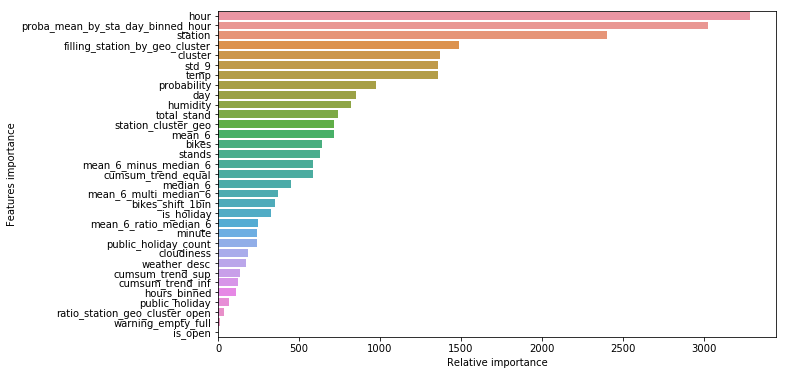

In [34]:
plot_features_importance(bst)

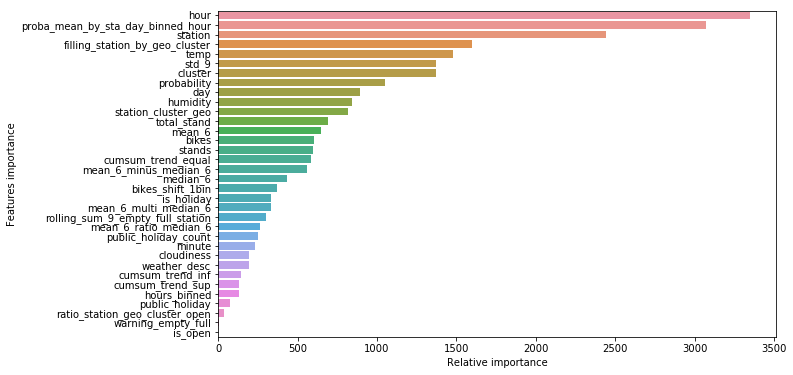

In [34]:
plot_features_importance(bst)

## Store the results

In [66]:
result = test_X.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq)

result['observation'] = test_Y.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq) ##??
result['prediction'] = pred
result['error'] = pred - test_Y
result['error_abs'] = np.abs(pred - test_Y)
result['relative_error'] = 100. * np.abs(pred - test_Y) / test_Y
result['quad_error'] = (pred - test_Y)**2
result.to_csv("prediction-freq-{}-{}.csv".format(freq, predict_date))

In [67]:
result.sort_values('error_abs', ascending=1).tail(10)

,station,bikes,stands,is_open,day,hour,minute,probability,is_holiday,public_holiday,...,humidity,weather_desc,cloudiness,ts_future,observation,prediction,error,error_abs,relative_error,quad_error
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-22 09:30:00,1021,1.0,10.0,1.0,4,9,30,0.090909,0,0,...,79,0,8,2017-09-22 10:30:00,0.727273,0.195490,-0.531782,0.531782,73.120075,0.282792
2017-09-22 09:10:00,9014,7.0,15.0,1.0,4,9,10,0.318182,0,0,...,79,0,8,2017-09-22 10:10:00,0.863636,0.324194,-0.539442,0.539442,62.461718,0.290998
2017-09-22 09:50:00,1021,1.5,9.5,1.0,4,9,50,0.136364,0,0,...,79,0,8,2017-09-22 10:50:00,0.818182,0.276557,-0.541625,0.541625,66.198607,0.293358
2017-09-22 09:10:00,7035,11.5,17.5,1.0,4,9,10,0.396552,0,0,...,79,0,8,2017-09-22 10:10:00,0.896552,0.354651,-0.541900,0.541900,60.442736,0.293656
2017-09-22 09:00:00,7035,12.0,17.0,1.0,4,9,0,0.413793,0,0,...,79,0,8,2017-09-22 10:00:00,0.965517,0.420354,-0.545164,0.545164,56.463375,0.297203
2017-09-22 10:00:00,8053,12.0,3.0,1.0,4,10,0,0.800000,0,0,...,79,0,8,2017-09-22 11:00:00,0.200000,0.749965,0.549965,0.549965,274.982655,0.302462
2017-09-22 09:00:00,10101,8.5,25.5,1.0,4,9,0,0.250000,0,0,...,79,0,8,2017-09-22 10:00:00,0.941176,0.367589,-0.573587,0.573587,60.943637,0.329002
2017-09-22 09:00:00,1032,4.0,18.0,1.0,4,9,0,0.181818,0,0,...,79,0,8,2017-09-22 10:00:00,0.863636,0.252201,-0.611436,0.611436,70.797811,0.373854
2017-09-22 09:00:00,4014,1.0,12.0,1.0,4,9,0,0.076923,0,0,...,79,0,8,2017-09-22 10:00:00,0.769231,0.145658,-0.623573,0.623573,81.064448,0.388843


In [68]:
trainning = X_train.copy()
train_pred = prediction(bst, X_train, y_train)
trainning['train_pred'] = train_pred
trainning['y'] = y_train 

# Sorting on time
trainning = trainning.sort_index()

In [69]:
trainning.head()

,station,bikes,stands,is_open,day,hour,minute,probability,is_holiday,public_holiday,...,mean_6_multi_median_6,mean_6_ratio_median_6,proba_mean_by_sta_day_binned_hour,minus_create_mean_by_sta_day_binned_hours_proba,temp,humidity,weather_desc,cloudiness,train_pred,y
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-01 02:00:00,3037,6.0,14.0,1.0,1,2,0,0.300000,1,0,...,0.090000,1.0,0.298516,-0.001484,22.16,47.0,0.0,0.0,0.299718,0.250000
2017-08-01 02:00:00,9040,11.0,1.0,1.0,1,2,0,0.916667,1,0,...,0.840278,1.0,0.610054,-0.306612,22.16,47.0,0.0,0.0,0.906871,0.916667
2017-08-01 02:00:00,6011,11.0,4.0,1.0,1,2,0,0.733333,1,0,...,0.537778,1.0,0.794324,0.060990,22.16,47.0,0.0,0.0,0.728479,0.733333
2017-08-01 02:00:00,10114,11.0,9.0,1.0,1,2,0,0.550000,1,0,...,0.302500,1.0,0.351540,-0.198460,22.16,47.0,0.0,0.0,0.566881,0.550000
2017-08-01 02:00:00,7004,29.0,1.0,1.0,1,2,0,0.966667,1,0,...,0.934444,1.0,0.934624,-0.032042,22.16,47.0,0.0,0.0,0.962215,0.966667


In [70]:
result['proba'] = result['bikes'] / (result['bikes'] + result['stands'])

In [120]:
from sklearn.metrics import mean_absolute_error

def plot_station(result, trainning, station, lag=750):
    """Plot available bikes and bike stands for a given station"""
    
    train = trainning[trainning.station == station].tail(lag)
    data = result[result.station == station].copy()
    
    fig, ax = plt.subplots(figsize=(18,5))
    plt.plot(train.index, train.y, '-', label='trainning target', alpha=0.6)
    plt.plot(train.index, train.train_pred, 'r--', label='trainning pred', alpha=0.4)
    #plt.plot(train.index, train.paa, '-', label='PAA', alpha=0.6)
    #plt.plot(train.index, train.sax, '-', label='SAX', alpha=0.6)
    plt.plot(data.index, data.observation, 'g-', label='Real')
    plt.plot(data.index, data.prediction, 'r-', label='Prediction')
    
    
    
    train['total_stand'] = train['bikes'] + train['stands']
    train['bikes_pred'] = np.round(train['total_stand'] * train['train_pred'])
    train['bikes_true'] = train['total_stand'] * train['y']
    
    data['total_stand'] = data['bikes'] + data['stands']
    data['bikes_pred'] = np.round(data['total_stand'] * data['prediction'])
    data['bikes_true'] = data['total_stand'] * data['observation']
    
    rmse_train = np.sqrt(np.mean((train.train_pred - train.y)**2))
    mae_train = mean_absolute_error(train.bikes_true, train.bikes_pred)
    rmse_test = np.sqrt(np.mean((data.prediction - data.observation)**2))
    mae_test = mean_absolute_error(data.bikes_true, data.bikes_pred)
    
    ax = plt.gca()
    # set major ticks location every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    # set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n\n%a %d.%m.%Y'))
    # set minor ticks location every two hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    # set minor ticks format
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    plt.legend(loc='best')
    print("RMSE train : " + str(np.round(rmse_train, 4)) + " - MAE : " + str(np.round(mae_train, 4)))
    print("RMSE test : " + str(np.round(rmse_test, 4)) + " - MAE : " + str(np.round(mae_test, 4)))

RMSE train : 0.1285 - MAE : 2.995
RMSE test : 0.2443 - MAE : 5.381


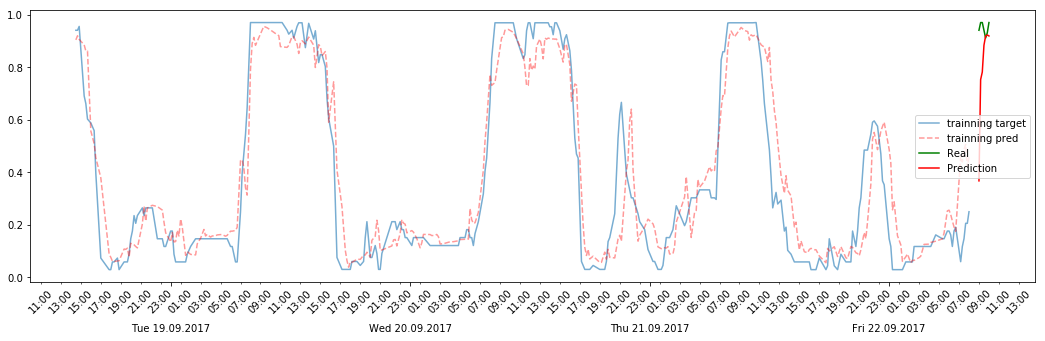

In [124]:
# Il semble que l'on est pas toute les données

plot_station(result, trainning, 10101, lag=350)

In [57]:
testing = result[result.station == 10113].copy()

In [58]:
testing = testing.reset_index()

In [59]:
testing.head()

,ts,station,bikes,stands,is_open,day,hour,minute,probability,is_holiday,...,ts_future,observation,prediction,error,error_abs,relative_error,quad_error,proba,bikes_pred,bikes_true
0,2017-09-22 09:00:00,10113,3.5,18.5,1.0,4,9,0,0.159091,0,...,2017-09-22 10:00:00,0.409091,0.156872,-0.252219,0.252219,61.653412,0.063614,0.159091,3.0,9.0
1,2017-09-22 09:10:00,10113,5.0,17.0,1.0,4,9,10,0.227273,0,...,2017-09-22 10:10:00,0.318182,0.230708,-0.087474,0.087474,27.491752,0.007652,0.227273,5.0,7.0
2,2017-09-22 09:20:00,10113,6.0,16.0,1.0,4,9,20,0.272727,0,...,2017-09-22 10:20:00,0.227273,0.238216,0.010943,0.010943,4.814914,0.000120,0.272727,5.0,5.0
3,2017-09-22 09:30:00,10113,7.0,15.0,1.0,4,9,30,0.318182,0,...,2017-09-22 10:30:00,0.181818,0.296440,0.114622,0.114622,63.042249,0.013138,0.318182,7.0,4.0
4,2017-09-22 09:40:00,10113,7.5,14.5,1.0,4,9,40,0.340909,0,...,2017-09-22 10:40:00,0.181818,0.339183,0.157365,0.157365,86.550783,0.024764,0.340909,7.0,4.0


In [60]:
station_result = result.groupby('station')[['bikes_true','bikes_pred']].apply(lambda row: mean_absolute_error(row.bikes_true, row.bikes_pred))
station_result_df = pd.DataFrame(station_result).reset_index()
station_result_df.columns = ['station', 'mae']

In [61]:
station_result_df.sort_values('mae')

,station,mae
116,5002,0.000000
263,9052,0.000000
261,9050,0.000000
258,9043,0.000000
216,8011,0.000000
262,9051,0.000000
133,5045,0.000000
114,4042,0.000000
129,5036,0.000000
322,10110,0.000000


In [160]:
testing.tail()

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,ts_future,observation,prediction,error,error_abs,relative_error,quad_error,proba,bikes_pred,bikes_true
2,2017-09-22 09:20:00,10113,6.0,16.0,1.0,4,9,20,0,0,...,2017-09-22 10:20:00,0.227273,0.308096,0.080823,0.080823,35.562210,0.006532,0.272727,7.0,5.0
3,2017-09-22 09:30:00,10113,7.0,15.0,1.0,4,9,30,0,0,...,2017-09-22 10:30:00,0.181818,0.287022,0.105204,0.105204,57.862130,0.011068,0.318182,6.0,4.0
4,2017-09-22 09:40:00,10113,7.5,14.5,1.0,4,9,40,0,0,...,2017-09-22 10:40:00,0.181818,0.287512,0.105694,0.105694,58.131635,0.011171,0.340909,6.0,4.0
5,2017-09-22 09:50:00,10113,8.5,13.5,1.0,4,9,50,0,0,...,2017-09-22 10:50:00,0.136364,0.298288,0.161924,0.161924,118.744284,0.026219,0.386364,7.0,3.0
6,2017-09-22 10:00:00,10113,9.0,13.0,1.0,4,10,0,0,0,...,2017-09-22 11:00:00,0.181818,0.278439,0.096620,0.096620,53.141180,0.009335,0.409091,6.0,4.0


## Signal transformation 

In [50]:
data.head(10)

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax,y,probability,prob_shit,prob_diff,prob_outlier
2402491,2017-09-19 07:00:00,12001,2.000000,23.000000,1.0,1,7,0,0,0,...,0.092000,0.102565,-0.010565,0.009436,0.896992,0.18,0.080000,0.080000,0.000000,0
2402830,2017-09-19 07:10:00,12001,2.500000,22.500000,1.0,1,7,10,0,0,...,0.092000,0.108671,-0.016671,0.009998,0.846590,0.16,0.100000,0.080000,0.020000,0
2403169,2017-09-19 07:20:00,12001,3.000000,22.000000,1.0,1,7,20,0,0,...,0.092000,0.114778,-0.022778,0.010560,0.801550,0.16,0.120000,0.100000,0.020000,0
2403508,2017-09-19 07:30:00,12001,5.000000,20.000000,1.0,1,7,30,0,0,...,0.092000,0.120884,-0.028884,0.011121,0.761061,0.20,0.200000,0.120000,0.080000,0
2403847,2017-09-19 07:40:00,12001,5.666667,19.333333,1.0,1,7,40,0,0,...,0.630667,0.602541,0.028126,0.380002,1.046679,0.20,0.226667,0.200000,0.026667,0
2404186,2017-09-19 07:50:00,12001,6.000000,19.000000,1.0,1,7,50,0,0,...,0.630667,0.608647,0.022020,0.383853,1.036178,0.20,0.240000,0.226667,0.013333,0
2404525,2017-09-19 08:00:00,12001,6.000000,19.000000,1.0,1,8,0,0,0,...,0.630667,0.614753,0.015913,0.387704,1.025886,0.16,0.240000,0.240000,0.000000,0
2404864,2017-09-19 08:10:00,12001,20.000000,5.000000,1.0,1,8,10,0,0,...,0.630667,0.620860,0.009807,0.391555,1.015796,0.16,0.800000,0.240000,0.560000,1
2405203,2017-09-19 08:20:00,12001,20.000000,5.000000,1.0,1,8,20,0,0,...,0.630667,0.626966,0.003701,0.395406,1.005903,0.16,0.800000,0.800000,0.000000,0
2405542,2017-09-19 08:30:00,12001,20.000000,5.000000,1.0,1,8,30,0,0,...,0.630667,0.633072,-0.002405,0.399257,0.996200,0.16,0.800000,0.800000,0.000000,0


In [69]:
def plot_station_transfo(data, station):
    """Plot available bikes and bike stands for a given station"""
    
    nb_row = 750
    data = data[data.station == station].tail(nb_row).copy()
    
    fig, ax = plt.subplots(figsize=(18,5))
    #plt.plot(train.index, train.sax, '-', label='SAX', alpha=0.6)
    plt.plot(data.index, data.y, 'g-', label='Real')
    plt.plot(data.index, data.paa, '-', label='PAA', alpha=0.6)
    #plt.plot(data.index, data.prediction, 'r-', label='Prediction')
    
    
    ax = plt.gca()
    # set major ticks location every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    # set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n\n%a %d.%m.%Y'))
    # set minor ticks location every two hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    # set minor ticks format
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    
    plt.legend(loc='best')

In [70]:
plot_station_transfo(data, 12001)

RuntimeError: Locator attempting to generate 1664626 ticks from 2396185.625 to 2534904.375: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 138719 ticks from 2396186.0 to 2534904.0: exceeds Locator.MAXTICKS

In [68]:
data[data.station == 12001][['ts', 'bikes', 'stands', 'y', 'paa']].tail(22)

,ts,bikes,stands,y,paa
2521480,2017-09-21 17:30:00,2.0,23.0,0.04,0.148
2521819,2017-09-21 17:40:00,1.0,24.0,0.04,0.148
2522158,2017-09-21 17:50:00,1.0,24.0,0.04,0.148
2522497,2017-09-21 18:00:00,1.0,24.0,0.04,0.040
2522836,2017-09-21 18:10:00,1.0,24.0,0.04,0.040
2523175,2017-09-21 18:20:00,1.0,24.0,0.04,0.040
2523514,2017-09-21 18:30:00,1.0,24.0,0.08,0.040
2523853,2017-09-21 18:40:00,1.0,24.0,0.08,0.040
2524192,2017-09-21 18:50:00,1.0,24.0,0.08,0.040
2524531,2017-09-21 19:00:00,1.0,24.0,0.08,0.040


In [66]:
data.loc[2528599]

ts                                2017-09-21 21:00:00
station                                         12001
bikes                                               2
stands                                             23
is_open                                             1
day                                                 3
hour                                               21
minute                                              0
is_holiday                                          0
public_holiday                                      0
public_holiday_count                                0
cluster                                             3
station_cluster_geo                                 3
ratio_station_geo_cluster_open                      1
bikes_shift_12Hmin                                  1
cumsum_trend_sup                                    1
cumsum_trend_inf                                    0
cumsum_trend_equal                                  0
was_recently_open           

## météo 

In [90]:
lyon_meteo = pd.read_csv('data/lyon_weather.csv', parse_dates=['date'])

In [91]:
lyon_meteo.rename(columns={'date':'ts'}, inplace=True)

In [92]:
lyon_meteo[55:62]

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
55,2017-08-01 09:20:00,800,Clear,24.47,21.0,26.0,1013.0,54,1.0,0
56,2017-08-01 09:30:00,800,Clear,24.47,21.0,26.0,1013.0,54,1.0,0
57,2017-08-01 09:40:00,800,Clear,25.46,22.0,27.0,1013.0,51,1.5,0
58,2017-08-01 10:00:00,800,Clear,25.46,22.0,27.0,1013.0,51,1.5,0
59,2017-08-01 10:10:00,800,Clear,26.71,22.0,29.0,1013.0,48,1.5,0
60,2017-08-01 10:20:00,800,Clear,26.70,22.0,29.0,1013.0,48,1.5,0
61,2017-08-01 10:30:00,800,Clear,26.70,22.0,29.0,1013.0,48,1.5,0


In [67]:
lyon_meteo.pressure.describe()

count    8714.000000
mean     1017.444658
std         4.307897
min       986.100000
25%      1015.000000
50%      1018.000000
75%      1020.000000
max      1025.000000
Name: pressure, dtype: float64

In [70]:
lyon_meteo[lyon_meteo.pressure >= 1020.000000].tail(10)

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
8704,2017-09-30 22:20:00,800,Clear,12.49,12.0,13.0,1022.0,87,2.1,0
8705,2017-09-30 22:30:00,800,Clear,12.48,12.0,13.0,1022.0,87,2.1,0
8706,2017-09-30 22:40:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8707,2017-09-30 22:50:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8708,2017-09-30 23:00:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8709,2017-09-30 23:10:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8710,2017-09-30 23:20:00,800,Clear,11.99,11.0,13.0,1022.0,93,1.0,0
8711,2017-09-30 23:30:00,800,Clear,11.99,11.0,13.0,1022.0,93,1.0,0
8712,2017-09-30 23:40:00,800,Clear,11.99,11.0,13.0,1022.0,93,1.0,0
8713,2017-09-30 23:50:00,803,Clouds,11.99,11.0,13.0,1022.0,93,1.5,75


In [58]:
lyon_meteo.weather_desc.unique()

array(['Clear', 'Thunderstorm', 'Clouds', 'Rain', 'Mist', 'Fog', 'Drizzle'], dtype=object)

In [60]:
LE = LabelEncoder()

In [61]:
lyon_meteo['weather_desc'] = LE.fit_transform(lyon_meteo['weather_desc'])

In [100]:
joblib.dump(LE, 'model/Label_Encoder_Weather.pkl') 

['model/Label_Encoder_Weather.pkl']

In [101]:
clf = joblib.load('model/Label_Encoder_Weather.pkl') 

In [104]:
clf.transform(['Cleare'])

ValueError: y contains new labels: ['Cleare']

In [62]:
lyon_meteo.tail()

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
8709,2017-09-30 23:10:00,800,0,12.23,11.0,13.0,1022.0,87,1.0,0
8710,2017-09-30 23:20:00,800,0,11.99,11.0,13.0,1022.0,93,1.0,0
8711,2017-09-30 23:30:00,800,0,11.99,11.0,13.0,1022.0,93,1.0,0
8712,2017-09-30 23:40:00,800,0,11.99,11.0,13.0,1022.0,93,1.0,0
8713,2017-09-30 23:50:00,803,1,11.99,11.0,13.0,1022.0,93,1.5,75


#### resample meteo

In [75]:
clean_lyon_meteo = lyon_meteo.resample("10T", on="ts").mean().bfill().reset_index()

In [76]:
clean_lyon_meteo[55:62]

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
55,2017-08-01 09:20:00,800.0,0.0,24.47,21.0,26.0,1013.0,54.0,1.0,0.0
56,2017-08-01 09:30:00,800.0,0.0,24.47,21.0,26.0,1013.0,54.0,1.0,0.0
57,2017-08-01 09:40:00,800.0,0.0,25.46,22.0,27.0,1013.0,51.0,1.5,0.0
58,2017-08-01 09:50:00,800.0,0.0,25.46,22.0,27.0,1013.0,51.0,1.5,0.0
59,2017-08-01 10:00:00,800.0,0.0,25.46,22.0,27.0,1013.0,51.0,1.5,0.0
60,2017-08-01 10:10:00,800.0,0.0,26.71,22.0,29.0,1013.0,48.0,1.5,0.0
61,2017-08-01 10:20:00,800.0,0.0,26.70,22.0,29.0,1013.0,48.0,1.5,0.0


#### Merging train_X

In [65]:
train_X.reset_index(inplace=True)

In [77]:
train_X.head()

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,station_cluster_geo,bikes_shift_1Hmin,cumsum_trend_sup,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax
0,2017-08-01 00:10:00,1001,10.0,6.0,1.0,1,0,0,1,0,...,5,10.0,0,0,0,1.0,16.0,0.456444,0.625000,0.623393
1,2017-08-01 00:10:00,1002,17.0,5.0,1.0,1,0,0,1,0,...,5,17.0,0,0,1,24.0,22.0,0.456444,0.570455,0.595576
2,2017-08-01 00:10:00,1003,14.0,1.0,1.0,1,0,0,1,0,...,5,14.0,0,0,1,24.0,15.0,0.456444,0.740000,0.767377
3,2017-08-01 00:10:00,1005,1.0,9.0,1.0,1,0,0,1,0,...,5,1.0,0,0,1,24.0,10.0,0.456444,0.125000,0.150893
4,2017-08-01 00:10:00,1006,11.0,11.0,1.0,1,0,0,1,0,...,5,11.0,0,0,3,24.0,22.0,0.456444,0.402273,0.430791


In [78]:
train_X.shape

(2554704, 22)

In [79]:
lol = train_X.merge(clean_lyon_meteo[['ts', 'temp', 'humidity', 'weather_desc']], on='ts', how='left')

In [80]:
pd.isnull(lol[['temp', 'humidity']]).sum()

temp        0
humidity    0
dtype: int64

In [81]:
lol.shape

(2554704, 25)

In [82]:
lol.head()

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,temp,humidity,weather_desc
0,2017-08-01 00:10:00,1001,10.0,6.0,1.0,1,0,0,1,0,...,0,0,1.0,16.0,0.456444,0.625000,0.623393,26.7,39.0,0.0
1,2017-08-01 00:10:00,1002,17.0,5.0,1.0,1,0,0,1,0,...,0,1,24.0,22.0,0.456444,0.570455,0.595576,26.7,39.0,0.0
2,2017-08-01 00:10:00,1003,14.0,1.0,1.0,1,0,0,1,0,...,0,1,24.0,15.0,0.456444,0.740000,0.767377,26.7,39.0,0.0
3,2017-08-01 00:10:00,1005,1.0,9.0,1.0,1,0,0,1,0,...,0,1,24.0,10.0,0.456444,0.125000,0.150893,26.7,39.0,0.0
4,2017-08-01 00:10:00,1006,11.0,11.0,1.0,1,0,0,1,0,...,0,3,24.0,22.0,0.456444,0.402273,0.430791,26.7,39.0,0.0


In [435]:
print(lyon_meteo.date.min())
print(lyon_meteo.date.max())

2017-08-01 00:10:00
2017-09-30 23:50:00


In [44]:
lyon_meteo = pd.read_csv('data/lyon_weather.csv', parse_dates=['date'])
lyon_meteo.rename(columns={'date':'ts'}, inplace=True)

# have to labelencode weather_desc
LE = LabelEncoder()
lyon_meteo['weather_desc'] = LE.fit_transform(lyon_meteo['weather_desc'])

# Dump LabelEncoder
joblib.dump(LE, 'model/Label_Encoder_Weather.pkl')

# Resemple data on 10
clean_lyon_meteo = lyon_meteo.resample("10T", on="ts").mean().bfill().reset_index()

In [45]:
clean_lyon_meteo.head()

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
0,2017-08-01 00:10:00,800.0,0.0,26.70,24.0,28.0,1011.0,39.0,3.1,0.0
1,2017-08-01 00:20:00,800.0,0.0,26.22,24.0,27.0,1011.0,39.0,1.0,0.0
2,2017-08-01 00:30:00,800.0,0.0,26.22,24.0,27.0,1011.0,39.0,1.0,0.0
3,2017-08-01 00:40:00,800.0,0.0,26.22,24.0,27.0,1011.0,39.0,1.0,0.0
4,2017-08-01 00:50:00,800.0,0.0,24.72,21.0,27.0,1011.0,44.0,1.5,0.0


In [46]:
X_train.head()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,station_cluster_geo,bikes_shift_1Hmin,cumsum_trend_sup,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-13 21:20:00,3067,14.0,1.0,1.0,2,21,10,0,0,0.0,...,2,13.5,2,0,0,24.0,15.0,0.422381,0.910000,0.884635
2017-08-29 16:40:00,7012,12.0,1.0,1.0,1,16,30,1,0,0.0,...,4,12.0,0,0,19,24.0,13.0,0.657379,0.923077,0.925245
2017-09-16 04:10:00,7010,6.0,14.0,1.0,5,4,0,0,0,0.0,...,0,5.0,1,0,0,24.0,20.0,0.660374,0.245000,0.266291
2017-08-28 15:30:00,8003,2.0,14.0,1.0,0,15,20,1,0,0.0,...,11,2.0,0,0,13,24.0,16.0,0.498904,0.125000,0.123527
2017-08-25 23:30:00,4006,1.0,21.0,1.0,4,23,20,1,0,0.0,...,8,1.0,0,0,21,24.0,22.0,0.349383,0.045455,0.046222


In [214]:
def get_weather(df, how='learning', freq=None):
    """
    Match timeseries with weather data.
    If type == learning :
        Matching with historitical data weather
    if type == forcast :
        Matching with forcast data. Freq must be fill with this opton
    """

    df = df.reset_index()

    # Check params
    if how not in ['learning', 'forecast']:
        logger.error('Bad option for get_weather. You must choose between learning or forecast')
        return df

    if how == 'forecast' and freq is None:
        logger.error("For forecast option, we must specify freq. Ex freq='1H'")


    # Process for learning matching
    if how == 'learning':
        lyon_meteo = pd.read_csv('data/lyon_weather.csv', parse_dates=['date'])
        lyon_meteo.rename(columns={'date':'ts'}, inplace=True)

        # have to labelencode weather_desc
        LE = LabelEncoder()
        lyon_meteo['weather_desc'] = LE.fit_transform(lyon_meteo['weather_desc'])

        # Dump LabelEncoder
        joblib.dump(LE, 'model/Label_Encoder_Weather.pkl')

        # Resemple data on 10
        clean_lyon_meteo = lyon_meteo.resample("10T", on="ts").mean().bfill().reset_index()
        df = df.merge(clean_lyon_meteo[['ts', 'temp', 'humidity', 'weather_desc']], on='ts', how='left')
        
        df = df.set_index('ts')
        return df

    # Process for forecast matching
    if how == 'forecast':
        lyon_forecast = pd.read_csv('data/lyon_forecast.csv', parse_dates=['forecast_at', 'ts'])
        lyon_forecast['delta'] = lyon_forecast['ts'] - lyon_forecast['forecast_at']

        # Filter on delta with freq
        lyon_forecast = lyon_forecast[lyon_forecast['delta'] == freq]
        lyon_forecast.drop_duplicates(subset=['ts', 'delta'], keep='first', inplace=True)
        
        # Label encode weather_desc
        LE = joblib.load('model/Label_Encoder_Weather.pkl') 
        lyon_forecast['weather_desc'] = LE.transform(lyon_forecast['weather_desc'])

        #Merging
        # We talk the last forecast (on freq) using backward merging
        df = df.sort_values('ts')
        df = pd.merge_asof(left=df, right=lyon_forecast[['ts','temp', 'humidity', 'weather_desc']], on='ts', direction='backward')

        df = df.set_index('ts')
        return df

In [53]:
del lol

### Forecast

In [88]:
lyon_forecast = pd.read_csv('data/lyon_forecast.csv', parse_dates=['forecast_at', 'ts'])

In [89]:
lyon_forecast.head()

,forecast_at,ts,weather_id,weather_desc,temp,temp_min,temp_max,rain_3h,snow_3h,pressure,humidity,wind_speed,cloudiness
0,2017-08-01,2017-08-01 02:00:00,800,Clear,26.06,26.06,26.16,NaN,NaN,982.16,36,6.51,8
1,2017-08-01,2017-08-01 05:00:00,800,Clear,25.64,25.64,25.72,NaN,NaN,981.74,36,7.09,8
2,2017-08-01,2017-08-01 08:00:00,500,Rain,25.83,25.83,25.88,0.025,NaN,982.54,44,6.83,20
3,2017-08-01,2017-08-01 11:00:00,500,Rain,29.75,29.75,29.77,0.160,NaN,983.02,44,6.05,0
4,2017-08-01,2017-08-01 14:00:00,803,Clouds,32.56,32.56,32.56,NaN,NaN,982.83,35,7.16,76


In [90]:
lyon_forecast.weather_desc.unique()

array(['Clear', 'Rain', 'Clouds'], dtype=object)

In [91]:
lyon_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86102 entries, 0 to 86101
Data columns (total 13 columns):
forecast_at     86102 non-null datetime64[ns]
ts              86102 non-null datetime64[ns]
weather_id      86102 non-null int64
weather_desc    86102 non-null object
temp            86102 non-null float64
temp_min        86102 non-null float64
temp_max        86102 non-null float64
rain_3h         25824 non-null float64
snow_3h         0 non-null float64
pressure        86102 non-null float64
humidity        86102 non-null int64
wind_speed      86102 non-null float64
cloudiness      86102 non-null int64
dtypes: datetime64[ns](2), float64(7), int64(3), object(1)
memory usage: 8.5+ MB


In [92]:
lyon_forecast['delta'] = lyon_forecast['ts'] - lyon_forecast['forecast_at']

In [93]:
lyon_forecast = lyon_forecast[lyon_forecast['delta'] == "1H"]
lyon_forecast.drop_duplicates(subset=['ts', 'delta'], keep='first', inplace=True)

In [126]:
LE = joblib.load('model/Label_Encoder_Weather.pkl') 
lyon_forecast['weather_desc'] = LE.transform(lyon_forecast['weather_desc'])

In [229]:
lyon_forecast[(lyon_forecast.ts >= "2017-08-01 07:00:00") & (lyon_forecast.delta == "1H")].head()

,forecast_at,ts,weather_id,weather_desc,temp,temp_min,temp_max,rain_3h,snow_3h,pressure,humidity,wind_speed,cloudiness,delta
273,2017-08-01 07:00:00,2017-08-01 08:00:00,500,5,20.82,20.82,25.88,0.025,NaN,982.54,44,6.83,20,01:00:00
385,2017-08-01 10:00:00,2017-08-01 11:00:00,500,5,29.44,29.44,29.77,0.160,NaN,983.02,44,6.05,0,01:00:00
494,2017-08-01 13:00:00,2017-08-01 14:00:00,803,1,31.95,31.95,32.56,NaN,NaN,982.83,35,7.16,76,01:00:00
600,2017-08-01 16:00:00,2017-08-01 17:00:00,802,1,30.55,30.07,30.55,NaN,NaN,983.80,48,5.96,48,01:00:00
720,2017-08-01 19:00:00,2017-08-01 20:00:00,804,1,27.31,27.31,27.99,NaN,NaN,985.40,55,2.58,88,01:00:00


In [153]:
#lyon_forecast[(lyon_forecast.ts >= "2017-08-01 00:10:00") & (lyon_forecast.delta == "1H")]

In [215]:
X_test.head(2)

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,station_cluster_geo,bikes_shift_1Hmin,cumsum_trend_sup,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-23 18:00:00,9010,10.0,9.0,1.0,2,18,0,1,0,0.0,...,1,10.0,0,0,6,24.0,19.0,0.596376,0.552632,0.550343
2017-09-16 14:30:00,1022,30.0,1.0,1.0,5,14,20,0,0,0.0,...,5,30.0,0,0,1,24.0,31.0,0.758573,0.686022,0.711584


In [216]:
lol = get_weather(X_test, how='forecast', freq='1H')

In [235]:
lol[lol.index.isin(['2017-08-01 10:00:00','2017-08-01 11:00:00'])].tail()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,temp,humidity,weather_desc
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-01 11:00:00,3088,14.0,2.0,1.0,1,11,0,1,0,0.0,...,0,1,24.0,16.0,0.664074,0.834375,0.836449,29.44,44,5
2017-08-01 11:00:00,6001,14.0,1.0,1.0,1,11,0,1,0,0.0,...,0,2,24.0,15.0,0.664074,0.926667,0.922586,29.44,44,5
2017-08-01 11:00:00,3029,4.0,19.0,1.0,1,11,0,1,0,0.0,...,1,0,24.0,23.0,0.421277,0.160870,0.163770,29.44,44,5
2017-08-01 11:00:00,4023,14.0,7.0,1.0,1,11,0,1,0,0.0,...,0,3,24.0,21.0,0.640138,0.650000,0.652840,29.44,44,5
2017-08-01 11:00:00,3051,11.0,2.0,1.0,1,11,0,1,0,0.0,...,0,6,24.0,13.0,0.537528,0.730769,0.731793,29.44,44,5


In [232]:
lol.head()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,temp,humidity,weather_desc
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-01 02:00:00,10088,18.0,1.0,1.0,1,2,0,1,0,0.0,...,0,2,24.0,19.0,0.460417,0.947368,0.948087,24.47,36,0
2017-08-01 02:00:00,10102,6.0,24.0,1.0,1,2,0,1,0,0.0,...,0,1,24.0,30.0,0.375505,0.200000,0.199909,24.47,36,0
2017-08-01 02:00:00,2014,1.0,15.0,1.0,1,2,0,1,0,0.0,...,0,2,24.0,16.0,0.363962,0.062500,0.063656,24.47,36,0
2017-08-01 02:00:00,4003,1.0,16.0,1.0,1,2,0,1,0,0.0,...,0,92,24.0,17.0,0.336585,0.058824,0.059792,24.47,36,0
2017-08-01 02:00:00,8008,4.0,9.0,1.0,1,2,0,1,0,0.0,...,0,1,24.0,13.0,0.853293,0.319231,0.292275,24.47,36,0


In [222]:
lyon_forecast[(lyon_forecast.ts >= "2017-08-01 07:00:00")].head(5)

,forecast_at,ts,weather_id,weather_desc,temp,temp_min,temp_max,rain_3h,snow_3h,pressure,humidity,wind_speed,cloudiness,delta
273,2017-08-01 07:00:00,2017-08-01 08:00:00,500,5,20.82,20.82,25.88,0.025,NaN,982.54,44,6.83,20,01:00:00
385,2017-08-01 10:00:00,2017-08-01 11:00:00,500,5,29.44,29.44,29.77,0.160,NaN,983.02,44,6.05,0,01:00:00
494,2017-08-01 13:00:00,2017-08-01 14:00:00,803,1,31.95,31.95,32.56,NaN,NaN,982.83,35,7.16,76,01:00:00
600,2017-08-01 16:00:00,2017-08-01 17:00:00,802,1,30.55,30.07,30.55,NaN,NaN,983.80,48,5.96,48,01:00:00
720,2017-08-01 19:00:00,2017-08-01 20:00:00,804,1,27.31,27.31,27.99,NaN,NaN,985.40,55,2.58,88,01:00:00


In [166]:
#X_test = X_test.reset_index()
#Merging
# We talk the last forecast (on freq) using backward merging
#X_test = X_test.sort_values('ts')
lol = pd.merge_asof(left=X_test, right=lyon_forecast[['ts','temp', 'humidity', 'weather_desc']], on='ts', direction='backward')

In [176]:
print(lyon_forecast.ts.min())
print(lyon_forecast.ts.max())

2017-08-01 02:00:00
2017-09-30 23:00:00


## Some maps

CSV file with station coordinates

In [48]:
locations = pd.read_csv("./data/lyon-stations.csv")

In [49]:
locations.shape

(348, 4)

Some stations were removed when the data were cleaned up. Remove them from the location data.

In [50]:
mask = locations['idstation'].isin(result.station.unique())

In [51]:
mask.sum()

337

In [52]:
locations = locations[mask]

In [53]:
locations = locations.rename_axis({'idstation': 'station'}, axis=1)

In [54]:
locations.head()

,station,nom,lat,lon
0,10027,Mairie de Villeurbanne,45.766831,4.879894
1,10030,Greuze,45.773844,4.893848
2,10034,MJC,45.761788,4.886157
3,10036,Chaplin / Dutriévoz,45.774357,4.859155
4,10038,Condorcet / 11 Nov. 1918,45.779046,4.866778


Some station names contains the `'` character. Replace it by the HTML code for folium.

In [78]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

Select the prediction data for a specific timestamp

In [79]:
data_to_plot = result.loc[predict_date]

In [80]:
data_to_plot.shape

(337, 12)

In [81]:
data_to_plot.head()

,station,bikes,stands,day,hour,minute,ts_future,observation,prediction,error,relative_error,quad_error
ts,,,,,,,,,,,,
2017-07-26 10:00:00,1001,2.0,14.0,2,10,0,2017-07-26 10:30:00,0.375000,0.140736,-0.234264,62.470392,0.054880
2017-07-26 10:00:00,1002,8.0,14.0,2,10,0,2017-07-26 10:30:00,0.255814,0.358517,0.102703,40.147679,0.010548
2017-07-26 10:00:00,1003,2.0,13.0,2,10,0,2017-07-26 10:30:00,0.133333,0.145994,0.012661,9.495718,0.000160
2017-07-26 10:00:00,1005,2.0,8.0,2,10,0,2017-07-26 10:30:00,0.300000,0.227014,-0.072986,24.328576,0.005327
2017-07-26 10:00:00,1006,2.0,19.0,2,10,0,2017-07-26 10:30:00,0.047619,0.109391,0.061772,129.721656,0.003816


In [83]:
yhat = data_to_plot[['station', 'prediction']].merge(locations, on='station')
yhat.head()

,station,prediction,nom,lat,lon
0,1001,0.140736,Terreaux / Terme,45.767735,4.832135
1,1002,0.358517,Opéra,45.767507,4.836282
2,1003,0.145994,Place Sathonay,45.769266,4.830080
3,1005,0.227014,Meissonier,45.766089,4.832890
4,1006,0.109391,Subsistances,45.767896,4.819817


In [104]:
y = data_to_plot[['station', 'observation']].merge(locations, on='station')

In [140]:
error = data_to_plot[['station', 'error']].merge(locations, on='station')

In [122]:
colormap = 'RdYlBu'
cmap = plt.get_cmap(colormap)

See 

* https://matplotlib.org/examples/color/colormaps_reference.html
* https://matplotlib.org/api/colors_api.html

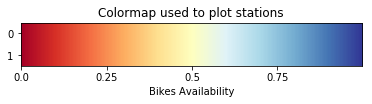

In [137]:
# show the colormap use to plot the stations, values [0, 1]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(1)
fig.subplots_adjust(top=0.95, bottom=0.80, left=0.2, right=0.99)
ax.set_xticks([0., 64, 128, 192, 256])
ax.set_xticklabels([0., 0.25, 0.5, 0.75, 1.])
ax.set_xlabel('Bikes Availability')
ax.imshow(gradient, aspect='auto', cmap=cmap, vmin=0, vmax=1)
plt.title('Colormap used to plot stations')

* Red stations if there are 0 or a few available bikes
* Blue stations if there are several available bikes

In [95]:
color = lambda x: mpl.colors.to_hex(cmap(x))

In [89]:
# Lyon (France) Position
position = [45.750000, 4.850000]

In [106]:
mp_pred = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [107]:
# Map of the predicted values
for _,row in yhat.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['prediction']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['prediction'])
    ).add_to(mp_pred)

In [102]:
mp_pred

In [108]:
# Map for the observation
mp_obs = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [109]:
# Map of the observations
for _,row in y.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['observation']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['observation'])
    ).add_to(mp_obs)

In [138]:
mp_obs

In [153]:
# Colormap for error (by default, the color map fits for [0, 1] values)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
color_error = lambda x: mpl.colors.to_hex(cmap(norm(x)))

In [154]:
# Map for the errors
mp_error = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [155]:
# Map of the errors
for _,row in error.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color_error(row['error']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color_error(row['error'])
    ).add_to(mp_error)

In [156]:
mp_error

## Stations lyon geo

In [23]:
station_lyon = pd.read_csv('data/lyon-stations.csv')

In [24]:
station_lyon.head()

,idstation,nom,lat,lon
0,10027,Mairie de Villeurbanne,45.766831,4.879894
1,10030,Greuze,45.773844,4.893848
2,10034,MJC,45.761788,4.886157
3,10036,Chaplin / Dutriévoz,45.774357,4.859155
4,10038,Condorcet / 11 Nov. 1918,45.779046,4.866778


In [25]:
X = station_lyon[['lat', 'lon']].copy()

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [27]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
k_means = KMeans(init='k-means++', n_clusters=12).fit(X_scale)

In [28]:
station_lyon['station_cluster_geo'] = k_means.labels_

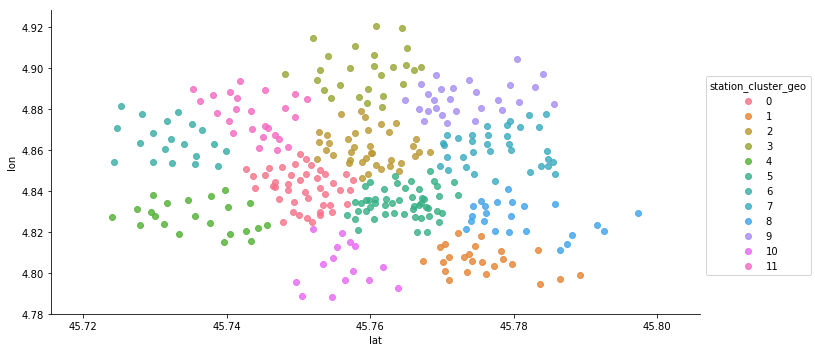

In [29]:
sns.lmplot(x="lat", y="lon", data=station_lyon, hue='station_cluster_geo', scatter=True, fit_reg=False, aspect=2)

In [30]:
# export 
station_lyon.head()
station_lyon.rename(columns={'idstation':'station'}, inplace=True)
station_lyon = station_lyon[['station', 'station_cluster_geo']]
station_lyon.to_csv('data/station_cluster_geo_armand.csv', index=False)